In [29]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(tsibble, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(lubridate, warn.conflicts = FALSE)
source("src/paths/paths.R")
source("src/analysis/data/quality_check.R")

begin_date <- as.Date("2000-01-01")
end_date <- as.Date("2022-12-31")


In [3]:
path.lom <- file.path(path.ds, "ARPA", "LOMBARDIA")
path.md <- file.path(path.lom, "Stazioni_Meteorologiche.tsv")

metadata <- read_tsv_arrow(path.md,
    col_types = schema(
        IdSensore = uint32(),
        IdStazione = uint32(),
        NomeStazione = utf8(),
        Tipologia = dictionary(),
        Provincia = dictionary(),
        DataStart = timestamp(unit = "s"),
        DataStop = timestamp(unit = "s"),
        Quota = float(),
        lng = float(),
        lat = float()
    ),
    timestamp_parsers = "%d/%m/%Y",
    as_data_frame = FALSE,
    col_select = c("IdSensore", "IdStazione", "NomeStazione", "Tipologia", "Provincia", "DataStart", "DataStop", "Quota", "lng", "lat")
) |>
    filter(Tipologia == "Temperatura") |>
    select(-Tipologia) |>
    mutate(across(starts_with("Data"), ~ cast(., date32()))) |>
    rename(identifier = IdSensore, anagrafica = NomeStazione, province = Provincia, elevation = Quota, lon = lng)
# filter(Tipologia == "Temperatura") |>
# select(!c(Tipologia, starts_with("UTM"), ends_with("Misura"), location, Storico)) |>
# mutate(DataStart = as.IDate(DataStart, format = "%d/%m/%Y"), DataStop = as.IDate(DataStop, format = "%d/%m/%Y"))


In [3]:
md <- metadata |> collect()
bind_rows(
    T_MIN = md, T_MAX = md, .id = "variable"
) |>
    as_arrow_table() |>
    mutate(
        identifier = cast(identifier, uint32()),
        IdStazione = cast(IdStazione, uint32()),
        province = cast(province, utf8()),
        across(c(elevation, lon, lat), ~ cast(., float()))
    ) |>
    write_feather(file.path("db", "metadata", "ARPA Lombardia.arrow"))


In [4]:
na_strings <- c("", "NA", "9999.0", "-9999.0", "-9999", "NV", "NC", "ND")

csv_schema <- schema(
    IdSensore = uint32(),
    Data = timestamp(unit = "s"),
    Valore = float32(),
    Stato = utf8(),
    idOperatore = uint8()
)
csv_parsers <- c("%d/%m/%Y %H:%M:%S", "%d/%m/%Y %H:%M:%S.000")

open_orig_ds <- function() {
    # open_csv_dataset(fs::dir_ls(path.lom, glob = "*.csv"),
    #     hive_style = FALSE,
    #     schema = csv_schema,
    #     timestamp_parsers = csv_parsers,
    #     na = na_strings,
    #     col_names = TRUE,
    #     skip = 1
    # ) |>
    #     rename(identifier = IdSensore, date = Data, value = Valore) |>
    #     filter(begin_date <= date, date <= end_date) |>
    #     semi_join(metadata, by = "identifier") |>
    #     # filter(abs(value) < 60) |>
    #     mutate(date = date - as.difftime(10 * 60, unit = "secs"))
    open_dataset(file.path("db", "data", "ARPA Lombardia"), format = "feather") |>
        filter(abs(value) < 60)
}

read_year <- function(name) {
    read_csv_arrow(file.path(path.lom, paste0(name, ".csv")),
        schema = csv_schema,
        timestamp_parsers = csv_parsers,
        as_data_frame = FALSE,
        skip = 1
    ) |> semi_join(metadata, by = "IdSensore")
}


compute_daily_stats <- function(ds) {
    ds |>
        group_by(identifier, date = date(date)) |>
        # reframe(value = range(value, na.rm = TRUE), variable = c("T_MIN", "T_MAX"))
        summarise(T_MIN = min(value, na.rm = TRUE), T_MAX = max(value, na.rm = TRUE), .groups = "drop")
}


In [9]:
open_orig_ds() |>
    mutate(value = if_else((Stato == "NA") | is.na(Stato), NA, value)) |>
    filter(!is.na(value)) |>
    compute_daily_stats() |>
    collect() |>
    pivot_longer(cols = c(T_MIN, T_MAX), names_to = "variable") |>
    as_arrow_table() |>
    mutate(identifier = cast(identifier, uint32()), value = cast(value, float())) |>
    write_dataset(file.path("db", "pieces", "lombardia_unchecked"),
        format = "feather",
        partitioning = "variable"
    )


In [22]:
data <- open_dataset(file.path("db", "pieces", "lombardia_unchecked"), format = "arrow")


In [32]:
qc1 <- data |> arrange(variable, identifier, date) |> gross_errors_check() |> collect() |> as_tsibble(key = c(variable, identifier), index = date) |> repeated_values_check()

In [36]:
qc1 |> filter(qc_repeated)

identifier,date,value,variable,qc_gross,qc_repeated
<int>,<date>,<dbl>,<chr>,<lgl>,<lgl>
4082,2005-07-30,-8.8,T_MAX,FALSE,TRUE
4082,2005-07-31,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-01,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-02,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-03,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-04,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-05,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-06,-8.8,T_MAX,FALSE,TRUE
4082,2005-08-07,-8.8,T_MAX,FALSE,TRUE


In [50]:
monthly_data <- ds |>
    compute_daily_stats() |>
    collect() |>
    group_by(IdSensore, mth = yearmonth(Date)) |>
    summarise(across(starts_with("T"), ~ mean(., na.rm = TRUE))) |>
    pivot_longer(c(T_MIN, T_MAX), names_to = "Variable") |>
    mutate(Variable = as.factor(Variable))


`summarise()` has grouped output by 'IdSensore'. You can override using the
`.groups` argument.


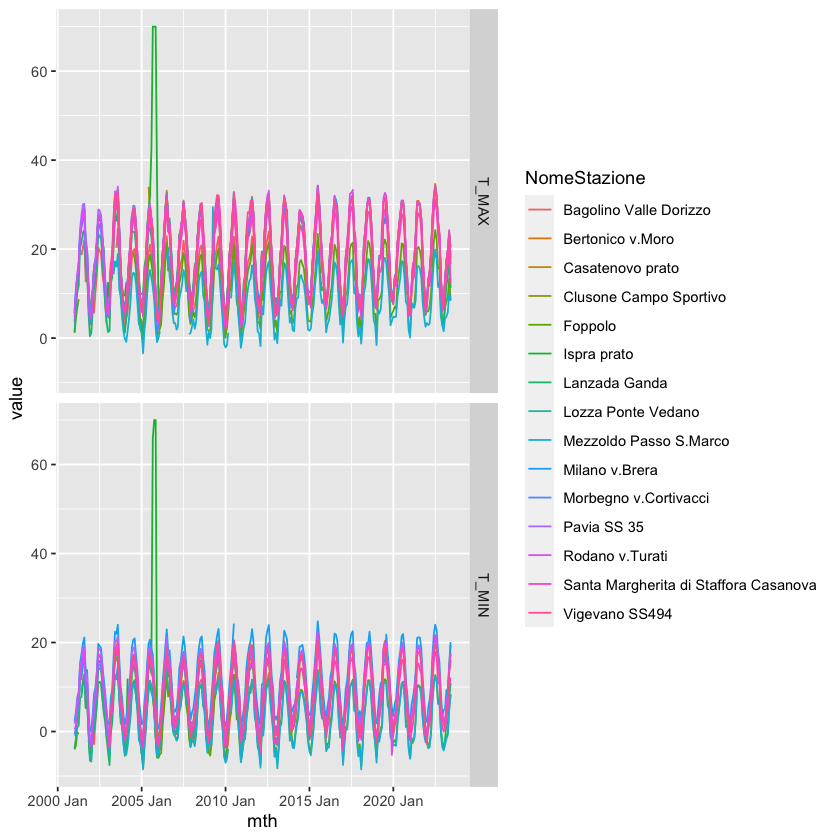

In [94]:
monthly_data |>
    as_tsibble(key = c(IdSensore, Variable), index = mth) |>
    fill_gaps() |>
    semi_join(metadata |> collect() |> sample_n(size = 15), by = "IdSensore") |>
    left_join(metadata |> collect(), by = "IdSensore") |>
    ggplot(aes(mth, value, color = NomeStazione)) +
    geom_line(na.rm = TRUE) +
    facet_grid(Variable ~ .)


In [15]:
source("src/analysis/data/clim_availability.R")
lomb_daily <- read_parquet(file.path(path.lom, "lombardia_daily_unchecked.parquet")) |>
    as_tsibble(index = Date, key = IdSensore) |>
    fill_gaps(.full = TRUE, .start = as.Date("2000-01-01"), .end = as.Date("2023-06-01"))


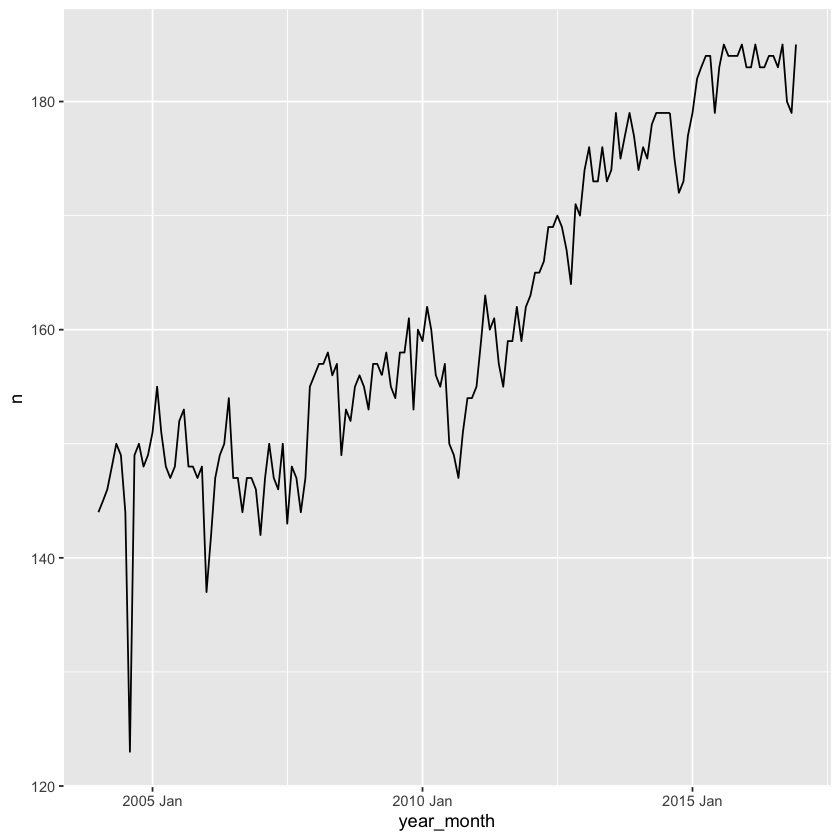

In [22]:
data |>
    collect() |>
    filter(year(date) >= 2004, year(date) <= 2016) |>
    as_tsibble(key = c(variable, identifier), index = date) |>
    fill_gaps(.full = TRUE) |>
    group_by_key() |>
    is_month_usable(value) |>
    summarise(n = sum(available)) |>
    ggplot(aes(year_month, n)) +
    geom_line()


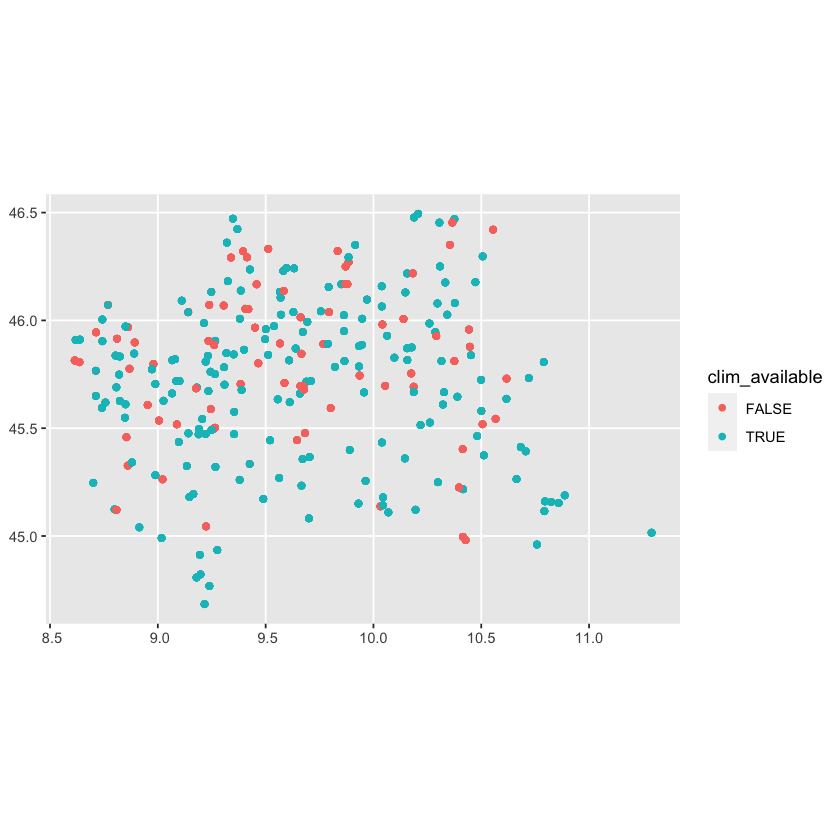

In [20]:
library(sf, warn.conflicts = FALSE)
lomb_daily |>
    rename(date = Date) |>
    group_by_key() |>
    is_climatology_computable(T_MIN, .start = as.Date("2004-01-01"), .end = as.Date("2022-12-31")) |>
    left_join(metadata |> collect(), join_by(IdSensore == identifier)) |>
    st_as_sf(coords = c("lon", "lat")) |>
    ggplot() +
    geom_sf(aes(color = clim_available))
